In [160]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from tqdm import tqdm
import numpy as np

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=True)

from torchvision.datasets import ImageFolder
import re

import sys
import os
sys.path.append('../')
from src import DATA_PATH, ROOT_PATH
DATA_PATH = f'{DATA_PATH}/OCT2017'
FIGURES_PATH = f'{ROOT_PATH}/reports/figures'

In [161]:
train = ImageFolder(f'{DATA_PATH}/train')
test = ImageFolder(f'{DATA_PATH}/test')
validation = ImageFolder(f'{DATA_PATH}/val')

In [162]:
train

Dataset ImageFolder
    Number of datapoints: 83484
    Root location: /Users/valik/Research/oct_diagn_semi_supervised/data/OCT2017/train

In [163]:
validation

Dataset ImageFolder
    Number of datapoints: 32
    Root location: /Users/valik/Research/oct_diagn_semi_supervised/data/OCT2017/val

In [164]:
test

Dataset ImageFolder
    Number of datapoints: 968
    Root location: /Users/valik/Research/oct_diagn_semi_supervised/data/OCT2017/test

In [165]:
train.classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

### Dataset distribution

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


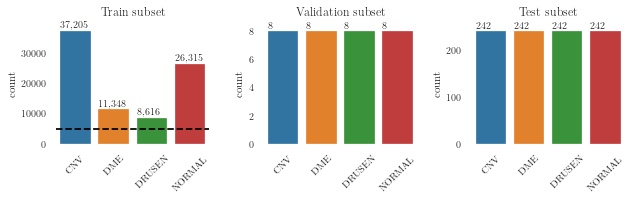

In [166]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

cnt_plt = sns.countplot([train.classes[i] for i in train.targets], ax=ax[0])
for p in cnt_plt.patches:
    cnt_plt.annotate('{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1000))
cnt_plt.set_title('Train subset', pad=10)
for n_l in [20000]:
    ax[0].axhline(n_l//4, color='black', ls='--')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='center')

cnt_plt = sns.countplot([validation.classes[i] for i in validation.targets], ax=ax[1])
for p in cnt_plt.patches:
    cnt_plt.annotate('{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+0.15))
cnt_plt.set_title('Validation subset', pad=10)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center')

cnt_plt = sns.countplot([test.classes[i] for i in test.targets], ax=ax[2])
for p in cnt_plt.patches:
    cnt_plt.annotate('{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+5))
cnt_plt.set_title('Test subset', pad=10)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='center')


fig.tight_layout(pad=1.5)

plt.savefig(f'{FIGURES_PATH}/dataset_dist.pdf')


In [181]:
targets = np.array(train.targets)
classes = np.arange(0, 4)
random_images = [np.random.choice(np.where(targets == cls)[0], 1)[0] for cls in classes]
random_images

[34189, 38304, 51238, 60240]

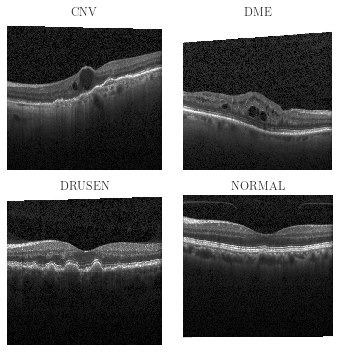

In [182]:
from PIL import Image
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for loc, rand_ind, cls_ind in zip([(0, 0), (0, 1), (1, 0), (1, 1)], random_images, classes):
    ax[loc].imshow(train[rand_ind][0])
    ax[loc].set_title(train.classes[cls_ind])
    ax[loc].set_axis_off()
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/dataset_sample.pdf')

### Other statistics

In [18]:
train_df = pd.DataFrame(train.imgs, columns=['filename', 'label'])
train_df['label'] = [train.classes[i] for i in train.targets]
train_df['img'] = train_df.filename.apply(os.path.basename)
get_patient = lambda img: img.replace('-',' ').replace('.',' ').split()[1]
train_df['patient'] = train_df.img.apply(get_patient)

test_df = pd.DataFrame(test.imgs, columns=['filename', 'label'])
test_df['label'] = [test.classes[i] for i in test.targets]
test_df['img'] = test_df.filename.apply(os.path.basename)
test_df['patient'] = test_df.img.apply(get_patient)

In [19]:
train_df.head(10)

,filename,label,img,patient
0,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-1.jpeg,1016042
1,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-10.jpeg,1016042
2,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-100.jpeg,1016042
3,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-101.jpeg,1016042
4,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-102.jpeg,1016042
5,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-103.jpeg,1016042
6,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-104.jpeg,1016042
7,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-105.jpeg,1016042
8,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-106.jpeg,1016042
9,/Users/valik/Research/oct_diagn_semi_supervise...,CNV,CNV-1016042-107.jpeg,1016042


In [9]:
# Same patient with different diagnoses?
train_df.groupby(['patient', 'label']).size()

patient  label 
1001666  DRUSEN      9
         NORMAL      1
1001772  DRUSEN      2
         NORMAL      8
1004480  NORMAL     14
                  ... 
9992052  NORMAL      2
9997417  CNV        10
9997680  CNV       274
         DME        20
         NORMAL      6
Length: 5620, dtype: int64

In [10]:
train_df[train_df.patient == '9997680'].label.value_counts()

CNV       274
DME        20
NORMAL      6
Name: label, dtype: int64

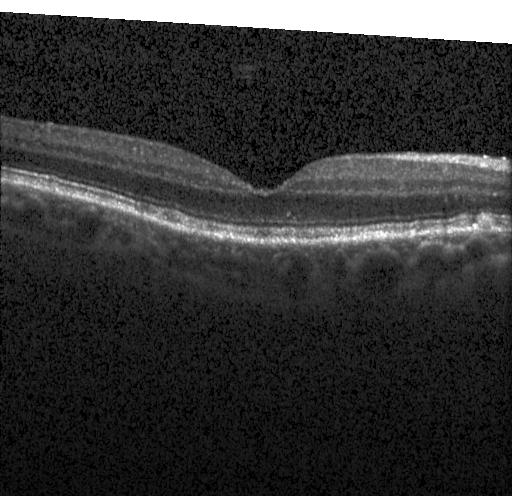

In [11]:
train[48553][0]

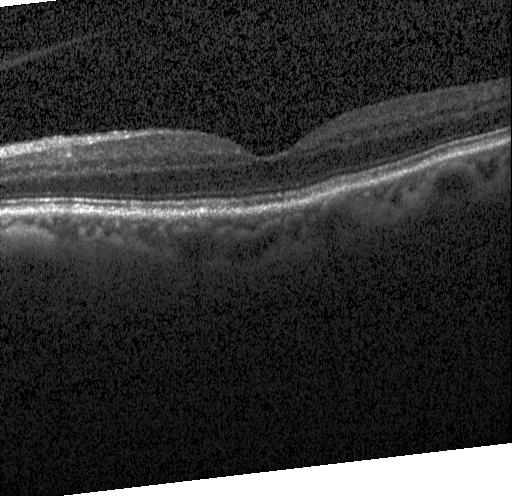

In [12]:
train[57169][0]

## Image sizes

In [50]:
sizes = []
for i in tqdm(range(len(train))):
    sizes.append(train[i][0].size)
for i in tqdm(range(len(validation))):
    sizes.append(validation[i][0].size)
for i in tqdm(range(len(test))):
    sizes.append(test[i][0].size)

100%|██████████| 968/968 [00:02<00:00, 393.44it/s]


In [51]:
sizes = np.array(sizes)

In [55]:
sizes = pd.DataFrame(sizes, columns=["width", "heigth"])

In [59]:
pd.crosstab(sizes.heigth, sizes.width)

width,384,512,768,1024,1536
heigth,,,,,
496,16,38661,21715,274,8362
512,0,15456,0,0,0


### Cropping scales discoveries

In [40]:
import torchvision.transforms as transforms
import ipywidgets as widgets
from ipywidgets import interact

def interact_scale(scale):
    rrc = transforms.RandomResizedCrop((512, 512), (scale, scale))
    return rrc(train[100][0])

In [46]:
interact(interact_scale, scale=widgets.FloatSlider(min=-0.0, max=1.0, step=0.1, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='scale', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.interact_scale(scale)>